# Imports

In [1]:
# Importing the required packages
from tqdm import tqdm
import datetime
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sb
import matplotlib.pyplot as plt
import time, sys

from functions.Systemic_Risk_Research_Statistical_Functions import*
from functions.Date_Function import*
from functions.Systemic_Risk_Z_Score import*

# Data Files

In [2]:
# importing the data 
RF_Data = pd.read_csv("C:\\Users\\Ritvik Bale\\Documents\\Research\\Systemic Risk Research\\Risk Factor Data v1.csv")
Bank_Data = pd.read_csv("C:\\Users\\Ritvik Bale\\Documents\\Research\\Systemic Risk Research\\Bank data v1 2020-08-24.csv")

# converting the raw data to DataFrames
RF_Data = pd.DataFrame(RF_Data)
Bank_Data = pd.DataFrame(Bank_Data)

# Adding Year, Month, and Day Columns to the DataFrames

In [3]:
#Adding Year, Month, and Day columns to the BankData Dataframe 
#This makes it easier to access the specific rows that we want

#Initializing the arrays that will store the Year, Month, and Day of all the rows in the BankData DataFrame
Year = []
Month = []
Day = []

for i in Bank_Data["date"]:    
    #Getting the Year, Month, and Day for each row in BankData DataFrame
    Year.append((datetime.datetime.strptime(str(i), "%Y%m%d")).year)
    Month.append((datetime.datetime.strptime(str(i), "%Y%m%d")).month)
    Day.append((datetime.datetime.strptime(str(i), "%Y%m%d")).day)
    
#Adding the Year, Month, and Day arrays as columns to the BankData DataFrame
Bank_Data["Year"] = Year
Bank_Data["Month"] = Month
Bank_Data["Day"] = Day

#Dropping Rows with Null Return Values
Bank_Data = Bank_Data.dropna(axis=0, subset=['RET'])
#Dropping Rows with values B and C
Bank_Data.drop(Bank_Data[Bank_Data.RET == 'B'].index, inplace=True)
Bank_Data.drop(Bank_Data[Bank_Data.RET == 'C'].index, inplace=True)
#Converting the Return Column to type Float
Bank_Data["RET"].astype(str).astype(float)

0       -0.082353
1       -0.174359
2        0.125000
3       -0.062500
4       -0.045926
           ...   
35829   -0.020362
35830   -0.041701
35831    0.064621
35832    0.000409
35833   -0.019877
Name: RET, Length: 35319, dtype: float64

In [4]:
Bank_Data.drop(Bank_Data[Bank_Data.RET == 'B'].index, inplace=True)
Bank_Data.drop(Bank_Data[Bank_Data.RET == 'C'].index, inplace=True)
Bank_Data["RET"].astype(str).astype(float)

0       -0.082353
1       -0.174359
2        0.125000
3       -0.062500
4       -0.045926
           ...   
35829   -0.020362
35830   -0.041701
35831    0.064621
35832    0.000409
35833   -0.019877
Name: RET, Length: 35319, dtype: float64

In [5]:
#Adding Year, Month, and Day columns to the RiskFactor Dataframe 
#This makes it easier to access the specific rows that we want

#Initializing the arrays that will store the Year, Month, and Day of all the rows in the RiskFactor DataFrame
Year = []
Month = []
Day = []

for i in RF_Data["Date"]:    
    #Getting the Year, Month, and Day for each row in the RiskFactor DataFrame
    Year.append((datetime.datetime.strptime(i, "%Y-%m-%d")).year)
    Month.append((datetime.datetime.strptime(i, "%Y-%m-%d")).month)
    Day.append((datetime.datetime.strptime(i, "%Y-%m-%d")).day)
    
#Adding the Year, Month, and Day arrays as columns to the RiskFactor DataFrame
RF_Data["Year"] = Year
RF_Data["Month"] = Month
RF_Data["Day"] = Day

In [6]:
#First few rows of BankData DataFrame
Bank_Data.head()

,PERMNO,date,SICCD,COMNAM,PERMCO,CUSIP,RET,Year,Month,Day
0,10071,19920331,6211,ALEX BROWN INC,8015,1390210,-0.082353,1992,3,31
1,10071,19920430,6211,ALEX BROWN INC,8015,1390210,-0.174359,1992,4,30
2,10071,19920529,6211,ALEX BROWN INC,8015,1390210,0.125,1992,5,29
3,10071,19920630,6211,ALEX BROWN INC,8015,1390210,-0.0625,1992,6,30
4,10071,19920731,6211,ALEX BROWN INC,8015,1390210,-0.045926,1992,7,31


In [7]:
#First few rows of RiskFactor DataFrame
RF_Data.head()

,Date,BOND,CREDIT,SP500,CMDTY,DVIX,DHOUSE,Unnamed: 7,Year,Month,Day
0,1975-02-01,0.0388,-14.02,0.1386,-0.1654,-3.8780,0.0024,NaN,1975,2,1
1,1975-03-01,0.0157,-12.54,0.0702,-0.1036,-1.6952,0.0004,NaN,1975,3,1
2,1975-04-01,-0.0142,-12.71,-0.0014,0.0908,-0.3795,-0.0012,NaN,1975,4,1
3,1975-05-01,-0.0093,-12.02,0.0691,-0.0435,-1.0668,0.0004,NaN,1975,5,1
4,1975-06-01,0.0120,-12.81,0.0538,-0.0270,-0.9265,0.0008,NaN,1975,6,1


# Initializing the Return Table

In [8]:
#Initializing the Return_Table that will consist of all the Bank Returns, and the corresponding Risk Factor Returns
Return_Table = []
Return_Table = pd.DataFrame(Return_Table)

#Adding Columns for the Year, Month, and Day (allows us to easily retrieve the corresponding Risk Factor Returns (by date))
Return_Table["Year"] = Bank_Data["Year"]
Return_Table["Month"] = Bank_Data["Month"]
Return_Table["Day"] = Bank_Data["Day"]

#Adding a PERMNO column(to be able to identify the firms), and a column consisting of all the Bank Returns
Return_Table["PERMNO"] = Bank_Data["PERMNO"]
Return_Table["Return"] = Bank_Data["RET"]

### Adding the Risk Factor Returns to the Return Table

In [9]:
#Initializing a Return Array for each Risk Factor
BOND = []
CREDIT = []
SP500 = []
CMDTY = []
DVIX = []
DHOUSE = []

In [10]:
#Adding all the corresponding Risk Factor Return values for each Bank Return entry (by date)
#Looping through the Bank Data DataFrame to find the Risk Factor returns for each date
for index, i in Bank_Data.iterrows():
    
    #Determining the year and month of row
    year = RF_Data["Year"] == i["Year"]
    month = RF_Data["Month"] == i["Month"]
    
    #Determining the row of Risk Factor Returns for the given date (year & month)
    Value = RF_Data[year & month]
    
    #Appending the Risk Factor Returns for the given date (year & month)
    BOND.append(np.array(Value["BOND"]))
    CREDIT.append(np.array(Value["CREDIT"]))
    SP500.append(np.array(Value["SP500"]))
    CMDTY.append(np.array(Value["CMDTY"]))
    DVIX.append(np.array(Value["DVIX"]))
    DHOUSE.append(np.array(Value["DHOUSE"]))

In [11]:
#Adding all of the Corresponding Risk Factor Return Arrays to the DataFrame
Return_Table["BOND"] = BOND
Return_Table["CREDIT"] = CREDIT
Return_Table["SP500"] = SP500
Return_Table["CMDTY"] = CMDTY
Return_Table["DVIX"] = DVIX
Return_Table["DHOUSE"] = DHOUSE

In [12]:
#First few rows of ReturnTable DataFrame
Return_Table.head()

,Year,Month,Day,PERMNO,Return,BOND,CREDIT,SP500,CMDTY,DVIX,DHOUSE
0,1992,3,31,10071,-0.082353,[-0.0015],[-3.676],[0.0106],[-0.0237],[-0.5],[0.0016]
1,1992,4,30,10071,-0.174359,[-0.0124],[-3.344],[-0.0178],[0.0306],[-0.65],[0.0009]
2,1992,5,29,10071,0.125,[-0.0006],[-3.179],[0.022],[0.0231],[-1.67],[0.0007]
3,1992,6,30,10071,-0.0625,[0.0066],[-3.319],[0.0159],[0.0243],[-0.51],[-0.0008]
4,1992,7,31,10071,-0.045926,[0.0078],[-3.212],[-0.0084],[-0.0041],[-0.18],[-0.0008]


# Coefficient (Beta) DataFrame Creation

In [13]:
def DateFunction(Return_Table, PERMNO, start_year, end_year, start_month, end_month):
    
    Coefficient_Table = []
    
    #Iterate over all firms
    for i in PERMNO:

        #Initializing the Coefficient_Table Array
        #Create a Return table for each firm - consisting of only the dates that have been specified
        Single_Firm = Return_Table.loc[Return_Table['PERMNO'] == i]
        
        #Modifying the DataFrame to only include returns from the specified dates
        Single_Firm = Single_Firm.loc[(Single_Firm.Year >= start_year) & (Single_Firm.Year <= end_year)]
        #Only including the dates that are after the start month of the start year
        Single_Firm = Single_Firm.loc[(Single_Firm.Month >= start_month) | (Single_Firm.Year > start_year)]
        #Only including the dates that are before the end month of the end year
        Single_Firm = Single_Firm.loc[(Single_Firm.Month <= end_month) | (Single_Firm.Year < end_year)]

        #Setting the X Variables to be regressed on (Risk Factors), and setting the Y Variable that will be regressed (Bank Returns)
        y = Single_Firm['Return']
        x = Single_Firm[['BOND', 'CREDIT', 'SP500', 'CMDTY', 'DVIX', 'DHOUSE']]

        #Conducting the Linear Regression
        if len(x['BOND']) > 1:
            
            reg = LinearRegression()
            reg = LinearRegression().fit(x, y)

            Coefficients = (reg.coef_)
            Coefficient_Table.append(Coefficients)
    
    #Formatting the Coefficient Table as a DataFrame
    Coefficient_Table = pd.DataFrame(Coefficient_Table, columns = ["BOND", "CREDIT", "SP500", "CMDTY", "DVIX", "DHOUSE"])
    return Coefficient_Table

In [14]:
PERMNO = Bank_Data["PERMNO"].unique()
Coefficient_Table = DateFunction(Return_Table, PERMNO, 1994, 1996, 2, 10)
Coefficient_Table

,BOND,CREDIT,SP500,CMDTY,DVIX,DHOUSE
0,-0.634473,0.014132,0.370269,0.350488,-0.018895,-17.207150
1,0.223860,-0.050587,-0.605033,-0.123392,0.001355,-60.962544
2,-0.028075,0.013901,0.002666,0.006515,-0.067879,0.000005
3,2.402920,-0.028174,1.461891,0.194486,-0.006493,37.999110
4,0.195546,-0.031802,0.492382,-0.331654,0.001006,11.662366
...,...,...,...,...,...,...
64,-8.182806,-0.489502,2.778228,-3.121804,0.020088,61.614551
65,0.093442,-0.320406,0.128247,0.015237,0.001289,-0.002002
66,-9.370323,-0.346071,1.356785,-0.929786,0.013584,-133.734773
67,-1.237850,-0.003816,0.725190,0.024368,-0.002587,-17.437861


# Statistical Analysis

## Running PCA to Determine the Level of Correlation

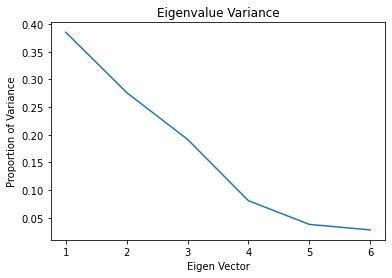

In [15]:
#Creating the Elbow Plot showing the Proportion of Variance explained by the Eigenvectors
plt.plot(range(1,7), PCA(Coefficient_Table)[1])
plt.title('Eigenvalue Variance')
plt.xlabel('Eigen Vector')
plt.ylabel('Proportion of Variance')
plt.show()

Cumulative Proportion of Variance

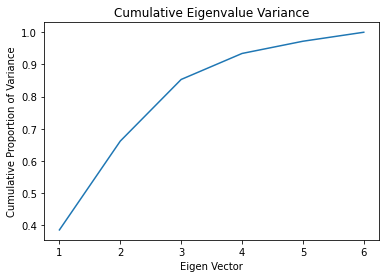

In [16]:
#Creating the Elbow Plot showing the Cumulative Proportion of Variance
plt.plot(range(1,7), PCA(Coefficient_Table)[2])
plt.title('Cumulative Eigenvalue Variance')
plt.xlabel('Eigen Vector')
plt.ylabel('Cumulative Proportion of Variance')
plt.show()

## Determining the Distance of the Points from the Line of Complete Systemic Risk

In [17]:
Distance_Function(Coefficient_Table)

-15.052362674074683

Standard Deviation of the Distances of all Firms

In [18]:
Distance_SD_Function(Coefficient_Table)

96.29165070606948

## Squared Weighted Systemic Risk

In [19]:
Squared_Beta_Function(Coefficient_Table)

201.17759359470006

## Measuring Clustering via the SD of the Points from the Mean Point

In [20]:
Clustering_SD_Function(Coefficient_Table)

84.14480019906664

## Running K-Means Clustering

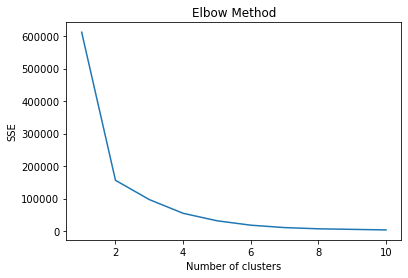

In [21]:
plt.plot(range(1, 11), KMeans_Clustering(Coefficient_Table))
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

# Constructing Distributions (unfinished)

In [22]:
def Generate_Dates(
    num_iterations: int,
    num_counter: int,
    start_year: int,
    end_year: int,
    start_month: int,
    end_month: int

):
    Dates = []

    for i in range(num_iterations):
       
       #The Incremented Month numbers
        s_value = start_month+(i*num_counter)
        e_value = end_month+(i*num_counter)
        
        #Adjusting such that the month values are between 1 and 12
        if s_value%12 == 0:
            s_month = 12
        else:
            s_month = s_value%12
        
        if e_value%12 == 0:
            e_month = 12
        else:
            e_month = e_value%12

        #Finding the minimum number of times 12 divides wholly into the number of months
        #This becomes the number of years to increment by
        s_year = (s_value - s_value%12)/12
        s_year = start_year+ s_year

        e_year = (e_value - e_value%12)/12
        e_year = end_year + e_year 

        #Appending the date to the 2D Array of all dates
        date = [s_year, e_year, s_month, e_month]
        Dates.append(date)
    
    Dates = pd.DataFrame(Dates)
        
    return(Dates)


def Distribution_Construction(
    Dates: np.ndarray,
    Return_Table: np.ndarray,
    PERMNO: np.ndarray,
    Function
):

    Function_Distribution = []
    num_iterations = Dates[0:][1]
    
    for i in range(len(num_iterations)):
        start_year = Dates[0][i]
        end_year = Dates[1][i]
        start_month = Dates[2][i]
        end_month = Dates[3][i]

        #Calculating the Coefficient Table for each Date in the Dates Array
        Coefficient_Table = DateFunction(Return_Table, PERMNO, start_year, end_year, start_month, end_month)

        #Calculting the Values of Each Statistical Function
        if Coefficient_Table.size > 1:
            Function_Value = Function(Coefficient_Table)
            Function_Distribution.append(Function_Value)
        
    return Function_Distribution


In [23]:
Dates = Generate_Dates(8, 6, 1994, 1996, 12, 6)

In [24]:
def Get_Market_Returns(
    market_name: str,
    RF_Data: np.ndarray,
    Dates
):
    #Initializing the array which will containg the returns of the Market
    Returns = np.array([])
    
    #Looping through all of the dates, and getting the appropriate Return
    for i in range((Dates.index).size):
        year = Dates[1][i]
        month = Dates[3][i]

        Return = RF_Data.loc[(RF_Data['Year'] == year) & (RF_Data['Month'] == month)]
        Returns = np.append(Returns, Return[market_name])
    
    return Returns

In [25]:
Returns = Get_Market_Returns('DVIX', RF_Data, Dates)

Distributions

In [26]:
Distribution = Distribution_Construction(Dates, Return_Table, PERMNO, Distance_Function)

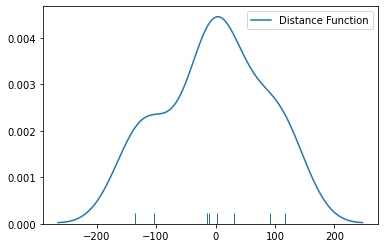

In [27]:
#Creating the Distribution
sb.distplot(Distribution, rug = True, hist = False, label = "Distance Function")

Z Score

In [28]:
def Z_Score_Function(
    Statistical_Values: np.ndarray,
    Market_Returns: np.ndarray
):
    #Initializing the X and Y Variables
    x = np.array(Statistical_Values).reshape(-1,1)
    y = Market_Returns

    #Running the Linear Regression
    Coefficients = []
    reg = LinearRegression().fit(x,y)
    Coefficients.append(reg.coef_)
    Coefficients.append(reg.intercept_)

    return Coefficients


In [29]:
Z_Score_Function(Distribution, Returns)

[array([0.00283757]), -1.6568235879865165]

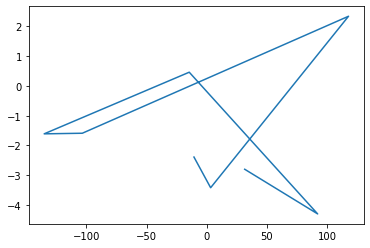

In [30]:
plt.plot(Distribution, Returns)